In [ ]:
import mmf_setup;mmf_setup.nbinit()
%pylab inline --no-import-all
from nbimports import *                # Conveniences like clear_output

from scipy.optimize import brentq
import math

from mmf_hfb import tf_completion as tf
reload(tf)
import mmf_hfb.FuldeFerrelState
reload(mmf_hfb.FuldeFerrelState)
from mmf_hfb.FuldeFerrelState import FFState as FF

# Polarized Vortex

We present here an analysis of a polarized vortex from the perspective of the Fulde-Ferrell (FF) state.  We start with the FF state in 1D.

## Check Thermodynamic Relations

In [8]:
mu = 10
dmu = 0.4
r = np.inf
delta0 = 1
ff = FF(dmu=dmu, mu=mu, delta=delta0, d=1, fix_g=False) # in 1d
def get_P(mu, dmu):
    mu_a = mu + dmu
    mu_b = mu - dmu
    delta = ff.solve(r=r, mu_a=mu_a, mu_b=mu_b)
    return ff.get_pressure(mu_a=mu_a, mu_b=mu_b, delta=delta, r=r)    

def get_E_n(mu, dmu=0):
    mu_a = mu + dmu
    mu_b = mu - dmu
    E = ff.get_energy_density(mu_a=mu_a, mu_b=mu_b, r=r)
    n = sum(ff.get_densities(mu_a=mu_a, mu_b=mu_b, r=r))
    return E, n

def get_ns(mu, dmu):
    mu_a = mu + dmu
    mu_b = mu - dmu
    return ff.get_densities(mu_a=mu_a, mu_b=mu_b, r=r)    

dx = 0.00001
E1, n1 = get_E_n(mu+dx)
E0, n0 = get_E_n(mu-dx)

print((E1-E0)/(n1-n0), mu)


dx = 1e-3
n_p = (get_P(mu+dx, dmu) - get_P(mu-dx, dmu))/2/dx
n_a, n_b = get_ns(mu, dmu)

print(n_p, n_a+n_b)

n_a_ = (get_P(mu+dx/2, dmu+dx/2) - get_P(mu-dx/2, dmu - dx/2))/2/dx
n_b_ = (get_P(mu+dx/2, dmu-dx/2) - get_P(mu-dx/2, dmu + dx/2))/2/dx
print(n_a, n_a_)
print(n_b, n_b_)

10.000+/-0.030 10
2.83684+/-0.00005 2.836835894+/-0.000000005
1.4184179471+/-0.0000000023 1.41842+/-0.00005
1.4184179471+/-0.0000000023 1.41842+/-0.00005


### Check Solution Ranges

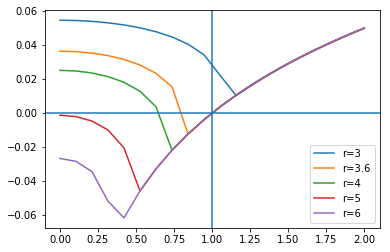

In [9]:
mu=10
dmu=.4
ff = FF(dmu=dmu, mu=mu, d=1)
deltas = np.linspace(0,2,20)
rs = [3,3.6,4,5,6]
for r in rs:
    fs = [ff.f(delta=delta, r=r, mu_a=mu+dmu, mu_b=mu-dmu) for delta in deltas]
    plt.plot(deltas, fs, label=f'r={r}')
plt.legend()
plt.axhline(0);plt.axvline(1)

### Compute $\Delta$ and densities in radius direction

In [10]:
mu=10
dmu=.4
def min_index(fs):
    min_value = fs[0]
    min_index = 0
    for i in range(1,len(fs)):
        if fs[i] < min_value:
            min_value = fs[i]
            min_index = i
    return min_index,min_value

def compute_delta_ns(rs, d=1):
    deltas=[]
    densities=[]
    ff = FF(dmu=1.4, mu=10, d=d)
    ds = np.linspace(0,1.5,10)
    for r in rs:
        fs = [ff.f(delta=delta, r=r, mu_a=mu+dmu, mu_b=mu-dmu) for delta in ds]
        index, value = min_index(fs)
        delta = 0
        if value < 0:
            delta = ff.solve(r=r,a= ds[index], mu_a=mu+dmu, mu_b=mu-dmu)
            #assert delta > 0
            if fs[0] > 0:
                smaller_delta = ff.solve(r=r,a=ds[0],b=ds[index], mu_a=mu+dmu, mu_b=mu-dmu)
                #print(f"a smaller delta={smaller_delta} is found for r={r}")
                p1 = ff.get_pressure(delta=delta, r=r, mu_a=mu+dmu, mu_b=mu-dmu)
                p2 = ff.get_pressure(delta=smaller_delta, r=r, mu_a=mu+dmu, mu_b=mu-dmu)
                print(f"p1={p1}\tp2={p2}")
                if(p2 > p1):
                    delta = smaller_delta
                #delta = smaller_delta

        deltas.append(delta)
        ns = ff.get_densities(delta=delta, r=r, mu_a=mu + dmu, mu_b=mu - dmu)
        densities.append(ns)
    return (deltas,densities)

In [11]:
deltas = []
densities = []
rs = np.linspace(0.1,1,10)
ds, ns = compute_delta_ns(rs)
deltas.extend(ds)
densities.extend(ns)

In [12]:
rs = np.linspace(2,4,20)
ds, ns = compute_delta_ns(rs)
deltas.extend(ds)
densities.extend(ns)

p1=18.8830391647+/-0.0000000011	p2=18.88294613+/-0.00000005
p1=18.891215383+/-0.000000009	p2=18.8907732344+/-0.0000000010
p1=18.89866069+/-0.00000006	p2=18.897654339+/-0.000000027
p1=18.905459649+/-0.000000032	p2=18.90371302+/-0.00000006
p1=18.911684944+/-0.000000020	p2=18.90905431+/-0.00000006
p1=18.91739932+/-0.00000008	p2=18.91376786+/-0.00000006
p1=18.92265719+/-0.00000033	p2=18.917930534+/-0.000000011
p1=18.92750590+/-0.00000015	p2=18.92160844+/-0.00000011


In [13]:
rs = np.linspace(4.1,8,20)
ds, ns = compute_delta_ns(rs)
deltas.extend(ds)
densities.extend(ns)

p1=18.93177092+/-0.00000004	p2=18.92470552+/-0.00000025
p1=18.93961364+/-0.00000008	p2=18.930027747+/-0.000000035
p1=18.946411117+/-0.000000010	p2=18.93420016+/-0.00000016
p1=18.95234113+/-0.00000018	p2=18.93745561+/-0.00000005
p1=18.95754521+/-0.00000005	p2=18.93997495+/-0.00000016


#### Plot $\Delta$ profile

Text(0, 0.5, '$\\Delta$')

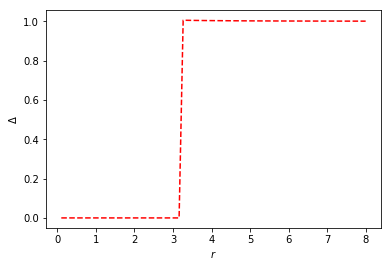

In [14]:
rs=np.append(np.linspace(0.1,1,10),[np.linspace(2,4,20),np.linspace(4.1,8,20)])
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.55, 0.4, 0.3, 0.4]
#ax2 = fig.add_axes([left, bottom, width, height])
offset = 10
ax1.plot(rs,deltas,'--', color='red')
#ax2.plot(rs[offset:],deltas[offset:],'--', color='green')
ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$\Delta$')

#### Plot density profiles

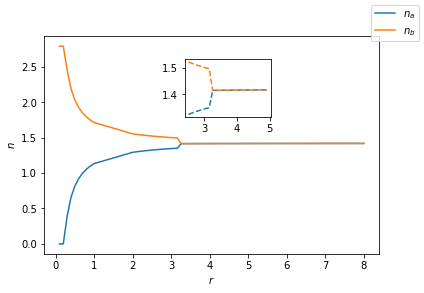

In [15]:
na=[]
nb=[]
for ns in densities:
    na.append(ns[0].n)
    nb.append(ns[1].n)
    
fig, ax1 = plt.subplots()

left, bottom, width, height = [0.45, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(rs,na,label=r"$n_a$")
ax1.plot(rs,nb,label=r"$n_b$")

ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$n$')
offset = 15
offset1 = offset + 20
ax2.plot(rs[offset:offset1],na[offset:offset1],'--')
ax2.plot(rs[offset:offset1],nb[offset:offset1],'--')
fig.legend()

#### Plot Current Profiles

The current for each component is defined:
$$
J_{a/b}(r) = n_{a/b}(r)  q=\frac{n_{a/b}(r)}{r}
$$

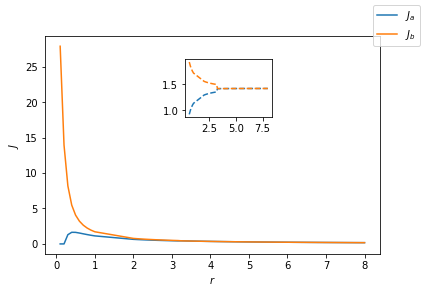

In [16]:
ja=[]
jb=[]
for i in range(len(rs)):
    ja.append(na[i]/rs[i])
    jb.append(nb[i]/rs[i])
    
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.45, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(rs,ja,label=r"$J_a$")
ax1.plot(rs,jb,label=r"$J_b$")

ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$J$')
offset = 5
ax2.plot(rs[offset:],na[offset:],'--')
ax2.plot(rs[offset:],nb[offset:],'--')
fig.legend()

## 2D Case
The 2d data is genereated by the temporarily test code in ['FuldeFerrelState.py'](FuldeFerrelState.py), then output file is a json text file ['delta_ns.txt'](delta_ns.txt) in the same folder as  ['FuldeFerrelState.py'](FuldeFerrelState.py), that take very long time to do. Once that is done, you may copy the ['delta_ns.txt'](delta_ns.txt) file to the Doc foler, and run code in this section to get the plots.
### Parallelization
* To compute the 2d FF state is slow slow, we need to go multi-processing
* Will be done in['FuldeFerrelState.py'](FuldeFerrelState.py) to generate the output
* Load the output file ['delta_ns.txt'](delta_ns.txt), and plot here

#### Load Data

In [17]:
import sys
import os
import inspect
from os.path import join
import json
from json import dumps
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
file = join(currentdir,"delta_ns.txt")
rs2 = []
deltas2 = []
na2 = []
nb2 = []
if os.path.exists(file):
    with open(file,'r') as rf:
        rs2,deltas2,na2,nb2 = json.load(rf)

#### Plot $\Delta$ Profile

Text(0, 0.5, '$\\Delta$')

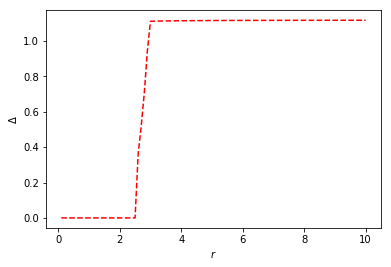

In [18]:
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.2, 0.45, 0.3, 0.4]
#ax2 = fig.add_axes([left, bottom, width, height])
offset = 10
ax1.plot(rs2,deltas2,'--', color='red')
#ax2.plot(rs2[offset:],deltas2[offset:],'--', color='green')
ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$\Delta$')

#### Plot Densities Profile

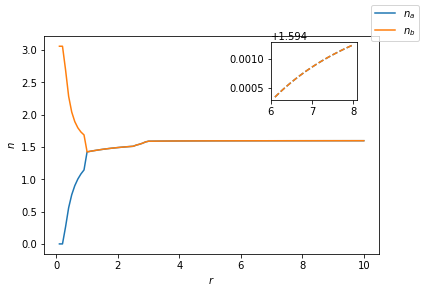

In [19]:
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.65, 0.66, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax1.plot(rs2,na2,label=r"$n_a$")
ax1.plot(rs2,nb2,label=r"$n_b$")
ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$n$')
offset =60
offset1 = offset + 20
ax2.plot(rs2[offset:offset1],na2[offset:offset1],'--')
ax2.plot(rs2[offset:offset1],nb2[offset:offset1],'--')
fig.legend()

#### Plot Current Profile

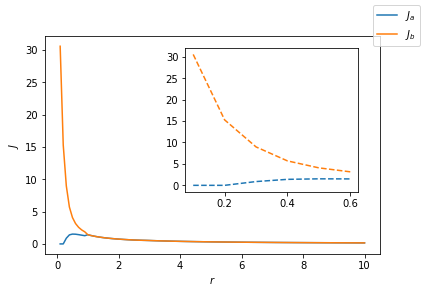

In [20]:
ja=[]
jb=[]
for i in range(len(rs2)):
    ja.append(na2[i]/rs2[i])
    jb.append(nb2[i]/rs2[i])
    
fig, ax1 = plt.subplots()

left, bottom, width, height = [0.45, 0.34, 0.4, 0.5]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(rs2,ja,label=r"$J_a$")
ax1.plot(rs2,jb,label=r"$J_b$")

ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$J$')
offset = 6
ax2.plot(rs2[:offset],ja[:offset],'--')
ax2.plot(rs2[:offset],jb[:offset],'--')
fig.legend()

### To-DO
* 1)<font color='red'> Review the literature and see if you can find some results for 1D or 2D FF states for reference.</font>
* 2)<font color='green'> Correctly implement the pressure and energy density and include high-precision tests of the thermodynamic relationships.</font>
* 3)<font color='green'> Correct the integrations in 2D.</font>

# Integrand Boundaries

Text(0, 0.5, '$C(q) - C(0)$')

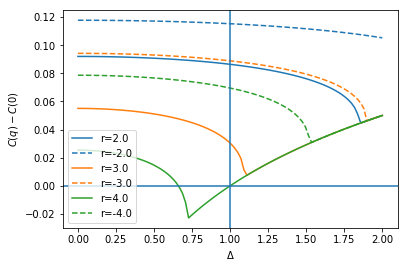

In [21]:
for r in [2.0, 3.0, 4.0]:
    q = 1/r
    mu = 10.0
    dmu = 0.4
    ff = FF(dmu=dmu, mu=mu, d=1)
    deltas = np.linspace(0, 2, 100)
    mu_a = mu + dmu + q**2/2
    mu_b = mu - dmu + q**2/2
    fs = [ff.f(delta=delta, r=r, mu_a=mu_a, mu_b=mu_b) for delta in deltas]
    l, = plt.plot(deltas, fs, label=f'r={r}')
    fs = [ff.f(delta=delta, r=-r, mu_a=mu_a, mu_b=mu_b) for delta in deltas]
    plt.plot(deltas, fs, '--', c=l.get_c(), label=f'r={-r}')

plt.legend()
plt.axhline(0);plt.axvline(1)
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$C(q) - C(0)$')

Here we see the behaviour of the gap equation for various values of $r=\hbar/q$.  We have shifted the chemical potential here by $q^2/2m$ so that the gap equation remains the same. The lower curve is the unrestricted integral ($p=\hbar k$):

$$
  \int\frac{\d{k}}{(2\pi)}\;
  \frac{1}{2\sqrt{\left(\frac{p^2}{2m}-\mu_q\right)^2 + \abs{\Delta}^2}} 
  - \tilde{C}(0), \qquad
  \mu_q = \mu - \frac{q^2}{2m}.
$$

The upper curves are the same integrand, but only over the regions where $\omega_+\omega_- < 0$, which is restricted at lower values of the gap.  We can find this value by solving the equations $\omega_{\pm}'(k) = 0$ and $\omega_{\pm}(k) = 0$ to obtain the following equations:

$$
  \pm p\epsilon_+ = q E, \qquad
  \epsilon_- = \mp E\\
  \frac{p}{q}\left(\frac{p^2}{2m} - \mu_q\right) 
  = \frac{pq}{m}+\delta = \pm E  
$$

$$
  q = \frac{-m\delta}{p} \pm \sqrt{p^2 - 2m\mu +\frac{m^2\delta^2}{p^2}}
$$

$$
  \mu_a = \mu_+ + \delta, \qquad
  \mu_b = \mu_- - \delta, \\
  \epsilon_+ = \frac{k^2}{2m} - \Bigl(\overbrace{\mu - \frac{q^2}{2m}}^{\mu_q}\Bigr),
  \qquad
  \epsilon_- = \frac{-\hbar^2 qk}{m} - \delta.
$$

$$
  (\d{\mu} - 2qk)^2 = \Delta^2 + (k^2/2 - \mu_q)^2
$$

$$
  \omega_\pm = \epsilon_- \pm E\\
  -2q \pm \frac{k\epsilon_+}{E} = 0
$$

$$
  4q^2(\epsilon_+^2 + \Delta^2) = 2(\epsilon_+ + \mu_q)\epsilon_+^2\\
  (\d{\mu} - 2qk)^2 - \Delta^2 = \epsilon_+^2
$$

$$
\pm\epsilon_+ k_z = 2q\sqrt{\epsilon_+^2 + \Delta^2}
$$

###  Determine Integrand Boundary
The $\frac{\nu}{\Delta}$ integral
\begin{align}
  \nu_c &= -\int_{c}\frac{\d^d{k}}{(2\pi)^d}\;\frac{\Delta}{2\sqrt{\epsilon_+^2 + \Delta^2}}
  &&\sim -\int_{c}\frac{\d^d{k}}{(2\pi)^d}\;\frac{m\Delta}{\hbar^2 k^2},\\
 \end{align}

In [22]:
def find_extremum(delta, mu, dmu, q=0,kp=0, hbar=1, m=1, a=0, b=5, N=20):
    kF = np.sqrt(2*mu*m)/hbar
    def f(k):
        ea = (k+q)**2 *hbar**2/2/m + (hbar*kp)**2/2/m - mu - dmu
        eb = (k-q)**2 * hbar**2/2/m  + (hbar*kp)**2/2/m - mu + dmu
        ep, em = (ea + eb)/2, (ea - eb)/2
        E = np.sqrt(ep**2 + delta**2)
        wp = em + E
        return ep * k - 2 * q *E#(ep * k)**2 - 4*q**2* E
    ks = np.linspace(a,b,N)
    plt.plot(ks,f(ks),'--')
    plt.axhline(0)
    try:
        return brentq(f,0.*kF,5*kF)
    except:
        return None

2.2360679774997894

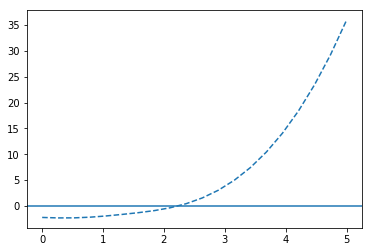

In [23]:
f = find_extremum(1,1,1,1)
f

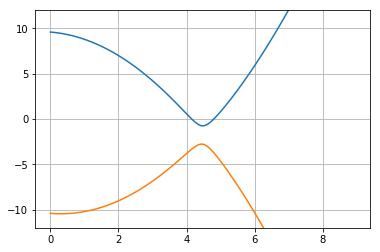

In [24]:
def plot_dispersion(delta, q, mu, dmu):
    kF = np.sqrt(2*mu)
    k = np.linspace(0, 2*kF, 100)
    ea, eb = (k+q)**2/2 - mu - dmu, (k-q)**2/2 - mu + dmu
    ep, em = (ea + eb)/2, (ea - eb)/2
    E = np.sqrt(ep**2 + delta**2)
    wp, wm = em + E, em - E
    plt.plot(k, wp)
    plt.plot(k, wm)
    plt.grid()
    plt.ylim(-12,12)

plot_dispersion(delta=1.0, mu=10.0, dmu=0.4, q=-1/3.3)
    

$$
  \Delta = e^{\I q x}\Delta_0
$$

In [ ]:
from mmf_hfb.tf_completion import nu_delta_integrand, C_integrand, integrate_q

In [ ]:
def plot_nu_delta(mu, dmu, kF, q=1/3, delta=1, GN=100):
    def integrand(kp, kz):
        k2_a = (kz+q)**2 + kp**2
        k2_b = (kz-q)**2 + kp**2
        return nu_delta_integrand(ka2=k2_a, kb2=k2_b,mu_a=mu+dmu, mu_b=mu+dmu,delta=1, m_a=1, m_b=1, hbar=1, T=0) / np.pi**2
    kzs = np.linspace(0,2*kF, GN)
    kps = np.linspace(0,2*kF, GN)
    pp,zz = np.meshgrid(kps,kzs)
    nu_delta = integrand(pp,zz)
    #plt.figure(figsize=(10, 5))
    imcontourf(kps, kzs, nu_delta, aspect=1);
    xx = np.linspace(0,1,GN) * kF
    yy = ((kF)**2 - xx**2)**0.5 
    plt.plot(xx,yy,c='r')
    plt.xlabel(r'$k_{\perp}$')
    plt.ylabel(r'$k_z$')
    plt.colorbar()
    
def plot_C1(mu, dmu, kF, q=1/3, delta=1, GN=100):
    def integrand(k):
        k2_a = (k+q)**2
        k2_b = (k-q)**2
        return C_integrand(ka2=k2_a, kb2=k2_b, mu_a=mu+dmu, mu_b=mu+dmu, delta=delta,  m_a=1, m_b=1, hbar=1, T=0) / np.pi**2
    ks = np.linspace(0,2*kF, GN)

    C_c = integrand(ks)
    plt.figure(figsize=(10, 5))
    plt.plot(ks,C_c,c='r')
    plt.axvline(kF)

def plot_C2(mu, dmu, kF, q=1/3, delta=1, GN=100):
    def integrand(kp, kz):
        k2_a = (kz+q)**2 + kp**2
        k2_b = (kz-q)**2 + kp**2
        return C_integrand(ka2=k2_a, kb2=k2_b, mu_a=mu+dmu, mu_b=mu+dmu, delta=delta, m_a=1, m_b=1, hbar=1, T=0) / np.pi**2
    kzs = np.linspace(0,2*kF, GN)
    kps = np.linspace(0,2*kF, GN)
    zz,pp = np.meshgrid(kzs,kps)
    nu_delta = integrand(pp,zz)
    xx = np.linspace(0,1,GN) * kF
    yy = (kF**2 - xx**2)**0.5 
    plt.figure(figsize=(10, 5))
    plt.plot(xx,yy,c='r')
    imcontourf(kps, kzs, nu_delta, aspect=1);
    plt.colorbar()
    
def plot_w(mu, dmu, q, delta=1, m_a=1, m_b=1, hbar=1, T=0, GN=100):
    mu_a, mu_b = mu + dmu, mu - dmu
    def func(kp,kz):
        ka2 = (kz+q)**2 + kp**2
        kb2 = (kz-q)**2 + kp**2
        e = hbar**2/2
        e_a, e_b = e*ka2/m_a - mu_a, e*kb2/m_b - mu_b
        e_m, e_p = (e_a - e_b)/2, (e_a + e_b)/2
        E = np.sqrt(e_p**2 + abs(delta)**2)
        w_m, w_p = e_m - E, e_m + E
        return w_m,w_p
    kzs = np.linspace(0,2*kF, GN)
    kps = np.linspace(0,2*kF, GN)
    zz,pp = np.meshgrid(kzs,kps)
    ws = func(pp,zz)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    imcontourf(kps, kzs, ws[0], aspect=1);
    plt.colorbar()
    plt.subplot(122)
    imcontourf(kps, kzs, ws[1], aspect=1);
    plt.colorbar()

In [ ]:
def find_delta_nu_extremum(delta, mu, dmu, q=0,kp=0, hbar=1, m=1, a=0, b=5, N=20):
    kF = np.sqrt(2*mu*m)/hbar
    def integrand(kp, kz):
        k2_a = (kz+q)**2 + kp**2
        k2_b = (kz-q)**2 + kp**2
        return nu_delta_integrand(ka2=k2_a, kb2=k2_b,mu_a=mu+dmu, mu_b=mu+dmu,delta=1, m_a=1, m_b=1, hbar=1, T=0) / np.pi**2
    
    def f(k):
        return integrand(k,kp)
    ks = np.linspace(a,b,N)
    plt.plot(ks,f(ks),'--')
    plt.axhline(0)
    kF = math.sqrt(2*(mu+dmu)/m) #
    plt.axvline(kF)
    try:
        return brentq(f,0.*kF,5*kF)
    except:
        return None

In [ ]:
GN =100
mu = 10
dmu = .4
q = 0
m_a, m_b = 1,1
delta = 0
minv = (1/m_a + 1/m_b)/2
kF = math.sqrt(2*(mu+dmu)/minv) #
#integrate_q(f=nu_delta_integrand, k_c=100*kF, mu_a=mu+dmu, mu_b=mu-dmu, q=q)
clear_output()
plot_nu_delta(mu=mu, dmu=dmu, kF=kF, q=q, delta=delta, GN=GN)

In [ ]:
kp=3.5
find_delta_nu_extremum(delta=delta, mu=mu, dmu=dmu, q=q, kp=kp,N=1000)

In [ ]:
find_extremum(delta=delta, mu=mu, dmu=dmu, q=q,kp=3.2,N=100)

In [ ]:
plot_C1(mu=mu, dmu=dmu, kF=kF, q=q,delta=delta, GN=GN)

In [ ]:
plot_C2(mu=mu, dmu=dmu, kF=kF, q=q,delta=delta, GN=GN)

In [ ]:
plot_w(mu=mu, dmu=dmu, q=q, delta=delta, GN=GN)

### Analysis
* From the above plot, we may find that the integral has a singular boundary belt which depends also on the $q$ and $d\mu$ or ($\mu s$), so we may need to carfully determine where that boundary spans.
* It can be found that: as $q$ larger than $k_F$, the singluar region would almost gone, and the inegral region become smooth.

### Fix the density and set $\kappa=0$

In [ ]:
np.random.seed(1)
m, hbar, kF = 1 + np.random.random(3)
eF = (hbar*kF)**2/2/m
nF = kF**3/3/np.pi**2
mu = 0.59060550703283853378393810185221521748413488992993*eF
q = 0
delta = None# 0.68640205206984016444108204356564421137062514068346*eF
delta = get_delta(mu_a= mu, mu_b=mu, m_a=m, m_b=m, q=q)
args = dict( d=3, delta=delta,mu_a=mu,mu_b=mu, m_a=m, m_b=m, hbar=hbar,q=q, T=0.0)

In [ ]:
np = tf.integrate_q(tf.n_p_integrand, **args)
nm = tf.integrate_q(tf.n_m_integrand, **args)

In [ ]:
def get_p(mu_a,mu_b):
    mu_p,mu_m = (mu_a + mu_b)/2, (mu_a - mu_b)/2
    return mu_p * np + mu_m * nm

In [ ]:
dmu = 1e-10
pa1 = get_p(mu+dmu,mu)
pa2 = get_p(mu-dmu,mu)
pb1 = get_p(mu,mu+dmu)
pb2 = get_p(mu,mu-dmu)
na_ = (pa1-pa2)/2/dmu
nb_ = (pb1-pb2)/2/dmu
na_,nb_,(np+nm)/2,(np-nm)/2

In [ ]:
import numpy as np
args = dict(delta=delta, m_a=m, m_b=m, hbar=hbar,q=q, T=0.0)
n_p = tf.integrate_q(tf.n_p_integrand, mu_a=mu,mu_b = mu,**args)
n_m = tf.integrate_q(tf.n_m_integrand, mu_a=mu,mu_b = mu,**args)
n_a = (n_p + n_m)/2
n_b = (n_p - n_m)/2
dmu = 1e-10
args = dict(delta=delta, hbar=hbar,q=q, T=0.0)
n0 = get_pressure(mu_a=mu, mu_b=mu, **args)
na1 = get_pressure(mu_a = mu - dmu,mu_b=mu, **args)
na2 = get_pressure(mu_a = mu + dmu,mu_b=mu, **args)
nb1 = get_pressure(mu_a = mu,mu_b=mu - dmu, **args)
nb2 = get_pressure(mu_a = mu,mu_b=mu + dmu, **args)
n_a_ = (na2 - na1)/2/dmu
n_b_ = (nb2 - nb1)/2/dmu
print((n_a,n_b),(n_a_,n_b_))
#assert np.allclose(n_a.n,n_a_.n)
#assert np.allclose(n_b.n,n_b_.n)

# Mixed states

$$
  \mu = \pdiff{\mathcal{E}(n)}{n}, \qquad
  n = \pdiff{P(\mu)}{\mu}, \qquad
  P = \mu n - \mathcal{E}, \qquad
  \mathcal{E} = \mu n - P,\\
  \mathcal{E}_1 = n^2, \qquad
  \mathcal{E}_2 = 1 + (n-1)^2\\
  \mu_1 = 2n, \qquad \mu_2 = 2(n-1)\\
  n_1 = \mu/2, \qquad n_2 = 1+\mu/2\\
  P_1 = \frac{\mu^2}{4}, \qquad
  P_2 = \mu - 1 + \frac{\mu^2}{4}
$$

First order transition at $\mu_c = 1$, $P=\mu_c^2/4$, with $n \in (\mu/2, 1 + \mu/2)$ and
$\mathcal{E} = \mu_c n - \mu_c^2/4$.

In [ ]:
n = np.linspace(0,2,100)
mu_c = 1
E1 = n**2
E2 = 1+(n-1)**2
n_mix = np.linspace(mu_c/2, 1+mu_c/2, 100)
E_mix = mu_c*n_mix - mu_c**2/4

plt.subplot(121)
plt.plot(n, E1, n, E2)
plt.plot(n_mix, E_mix, '-k')
plt.xlabel(r'$n$'); plt.ylabel(r'$\mathcal{E}$');

mu = np.linspace(0, 2, 100)
P1 = mu**2/4
P2 = mu**2/4 + mu - 1
ax = plt.subplot(122); ax.yaxis.tick_right()
plt.plot(mu, P1, mu, P2)
plt.plot(mu, np.maximum(P1, P2), 'k')
plt.xlabel(r'$\mu$'); plt.ylabel('$P$');

# FF States

In [ ]:
Delta = 0.1
k_z = np.linspace(0, 2, 100)
k_perp = 0.9
q = .0
kF = 1.0

dmu = 1.1*Delta
E = np.sqrt(((k_z**2 + k_perp**2 + q**2)/2 - kF**2/2)**2 + Delta**2)
Em = 2*q*k_z - dmu
wp = Em + E
wm = Em - E

plt.plot(k_z, wp)
plt.plot(k_z, wm)
plt.axhline(0, ls=':', c='y')


# Scattering length check in unitary case

In [ ]:
h3 = Homogeneous3D(T=0.0)
k0 = 1.0
mu = k0**2/2
eF = mu/0.5906055
kF = np.sqrt(2*eF)
n_p = kF**3/3/np.pi**2
mus_eff = (mu,)*2
delta =  1.16220056*mus_eff[0]
k_c = 10.0
Lambda = h3.get_inverse_scattering_length(mus_eff=mus_eff, delta=delta, k_c=k_c)/4/np.pi
Lambda, -k_c/2/np.pi**2*k0/2/k_c*np.log((k_c+k0)/(k_c-k0)),k0**3/3/np.pi**2 

In [ ]:
kc =np.linspace(1,20,20)
plt.plot(kc,[h3.get_inverse_scattering_length(mus_eff=mus_eff, delta=delta, k_c=k)/4/np.pi for k in kc])

In [ ]:
kc =np.linspace(20,200,20)
plt.plot(kc,[h3.get_inverse_scattering_length(mus_eff=mus_eff, delta=delta, k_c=k)/4/np.pi for k in kc])